## LLM Introduction



## Language models probabilistic formulation

Large language models are trained from discrete tokens. For ease of understanding equate roughly a token to a word. Say we have a super set of tokens $T = \{t_1, t_2,...t_n\}$ from which we create training dataset to train large language model. Here is a single record pair passed to train the model.

$$
x_1 = \{t_1, t_2, t_3, t_4 \}
y_1 = \{t_2, t_3, t_4, t_5 \}
$$

The labels are created from x by sliding one step to the right. How much to slide is a design choice. Also the length of input is predefined, commonly known as context length. When we llama-2 has a context length of 4K, we know that each instance of its training record had 4K tokens. You should be quick to notice here that we don't need a separate label records or class information for each of our input. The output y values can be derived automatically from the input x. This makes creating a dataset for a language model much easier. We dont need separate time and resource to create a labelled dataset.

If you have trouble with these notation, here is a python snippet where we represent token superset and training samples using words.



In [28]:

text = "Large language models are deep neural network trained on vast amount of text data."
T = list(set([x for x in text.split(" ")]))

print(f"Tokens superset \n {T}")


X = []
y = []

k=3
for i in range(len(T)-k):
    X.append(T[i:i+k])
    y.append(T[i+1:i+k+1])

print(f"Training Instances")

for x,y in zip(X,y):
    print(f"X: {x} y: {y}")

Tokens superset 
 ['on', 'deep', 'text', 'data.', 'trained', 'Large', 'amount', 'neural', 'models', 'language', 'are', 'network', 'of', 'vast']
Training Instances
X: ['on', 'deep', 'text'] y: ['deep', 'text', 'data.']
X: ['deep', 'text', 'data.'] y: ['text', 'data.', 'trained']
X: ['text', 'data.', 'trained'] y: ['data.', 'trained', 'Large']
X: ['data.', 'trained', 'Large'] y: ['trained', 'Large', 'amount']
X: ['trained', 'Large', 'amount'] y: ['Large', 'amount', 'neural']
X: ['Large', 'amount', 'neural'] y: ['amount', 'neural', 'models']
X: ['amount', 'neural', 'models'] y: ['neural', 'models', 'language']
X: ['neural', 'models', 'language'] y: ['models', 'language', 'are']
X: ['models', 'language', 'are'] y: ['language', 'are', 'network']
X: ['language', 'are', 'network'] y: ['are', 'network', 'of']
X: ['are', 'network', 'of'] y: ['network', 'of', 'vast']



While we train the model, it learns to predict $t_5$ given ${t_1,t_2,t_3,t_4}$. To simply put it we are training the model to do next word prediction. These are called as autoregressive models or causal models. We train a model with $\theta$ parameters. Our objective is to find the best parameters $\theta$ so that *likelihood* of this model predicting the correct following token, given a bunch of tokens is very high. Remember these are probabilistic models. So the likelihood of a language model for given training example $(x_i, y_i)$ is the probability the model assings to the correct $y_i$. In our example


$$
x_1 = \{t_1, t_2, t_3, t_4 \}
y_1 = \{t_2, t_3, t_4, t_5 \}
$$

We expect the model to assign high probability for $t_5$ given that our input to the model is $\{t_1, t_2, t_3, t_4 \}$.

In simpler terms, let us say our superset of tokens is of length 5, with a context size of 2 and sliding of one, we want maximum probabilities for $t_3, t_4, t_5$ to be the next token prediction for their respective inputs.

$$
P(X, \theta) = P(t_3 | t_2,t_1) * P(t_4|t_3,t_2) * P(t_5|t_4,t_3)
$$

Finally when the model is trained, we want the model to give maximum probabilities for $P(t_3 | t_2,t_1), P(t_4|t_3,t_2), P(t_5|t_4,t_3)$. Say if you encounter a scenario where

$$
P(t_3 | t_2,t_1) < P(t_4 | t_2,t_1)
$$

We know our model is not trained properly. Since each training pair is independent of the other, we can multiply their probabilities. Our aim in fitting a model is to arrive at best parameters $\theta$ which can maximize these probability. 

All these probabilities are very small values. Mutliplying them will further reduce these values and may lead to numerical stability issues due to the limited precision of floating point numbers. For float32 datatype the smallest number is close to $10^-45$. We can leverage by moving to log scale. 

$$
log(P(X, \theta)) = log(P(t_3 | t_2,t_1)) + log(P(t_4|t_3,t_2)) + log(P(t_5|t_4,t_3))
$$

The below python snippet explains how we can move to log scale and still face no impediments in that process. The log functions are stricly monotonic in nature and hence they help us with the scale of our values and successfully address numerical instability issues.

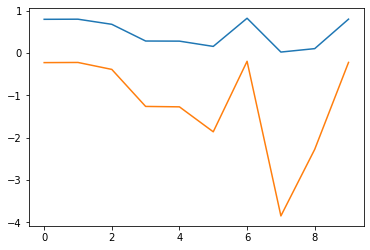

In [29]:
import matplotlib.pyplot as plt
import numpy as np

fx = lambda x: np.sin(x)
lfx = lambda x: np.log(np.sin(x))

x = np.random.random(10)


plt.plot(fx(x))
plt.plot(lfx(x))

Logarithms are *stricly monatonic*. They change the values, but not does not changes the shape, you see that peaks and valleys are same for both the functions in the above example. fx and lfx are two functions, where the second is a log of values thrown by the first function. Coming back to our equation, we can write the log likelihood in a generic way.

For super set of tokens $T = \{t_1, t_2,...t_n\}$, say context length is k, we can write above equation as

$
log(P(X,\theta)) = \sum_{i=1}^n log(P(t_i+k|t_i-k,..t_i+1,t_i))
$

As said earlier our objective is to build a model, which has the right parameters $\theta$, such that the output probabilities of correct output token is maximum. In other words, we want our $\theta$ such that value of the above equation is at the highest. To further iron it out, say we have two models, the first model has parameters $\theta_1$ and the second model has parameters $\theta_2$ if

$
log(P(X,\theta_1)) >> log(P(X,\theta_2))
$

we can conclude that our second model is superior to our first model. We say that we want to maximize the log-likelihood equation. The figure below shows the a sample input and corresponding output produced by the model.

```{figure} ../images/llm_io.jpg
---
height: 150px
name: llm-io-fig
---
Input and output to a language model
```

For illustration we have assumed context length as two. So for token 1 and token 2, the model predicts a distribution over all the tokens in the superset. For token 1, you can see that we have logits values for all the tokens $t_1 to t_5$. These values dont sum up to one, they can be passed to a softmax normalization later to be normalized. We expect that when the model is trained, for token $t_1$, the model should assign high logit value to $t_2$ and similarly for $t_2$ high logit values for $t_3$. Say we have n pairs of training data. We can rewrite our objective equation as

$$
log(P(X, \theta)) = \frac{1}{n}.\sum_{i=1}^n p_i^{True}.log(p_i)
$$

See the python code here for token $t_2$


In [32]:
y_true = [0.,0.,1.,0.,0.]
y_predicted = [.23,.002,.789,.654,.567]

sum([x*y for x,y in zip(y_true, y_predicted)])

0.789

Since its a standard for optimizers to use the minimize operation, we we take the negative of our objective function.

$$
NLL = -\frac{1}{n}.\sum_{i=1}^n p_i^{True}.log(p_i)
$$

This is the negative log-


For those new to LLMs, we will run ollama service to play with some popular large language models.

## Ollama

Ollama enables us to run open source LLMs locally. A tool that enables local deployment of large language models. A great tool for experimetning with LLMs. No need cloud hosting.
http://github.com/ollama/ollama. Refer to the website for installation.

Advantages for using Ollama,

1. Quick iteratvie development without needing to deploy model changes
2. Privacy and security - data does not leave your machine.
3. cost - more cost effective than making API calls.
4. control - more control over the model

    curl  -fsSL https://ollama.com/install.sh | sh

    >>> Installing ollama to /usr/local/bin...
    >>> Creating ollama user...
    >>> Adding ollama user to render group...
    >>> Adding ollama user to video group...
    >>> Adding current user to ollama group...
    >>> Creating ollama systemd service...
    >>> Enabling and starting ollama service...
    Created symlink /etc/systemd/system/default.target.wants/ollama.service → /etc/systemd/system/ollama.service.
    >>> NVIDIA GPU installed.

    sudo systemctl status ollama
    ● ollama.service - Ollama Service
         Loaded: loaded (/etc/systemd/system/ollama.service; enabled; vendor preset: enabled)
         Active: active (running) since Sat 2024-05-11 19:59:42 EDT; 5min ago
       Main PID: 1053781 (ollama)
          Tasks: 18 (limit: 18827)
         Memory: 480.5M
         CGroup: /system.slice/ollama.service
                 └─1053781 /usr/local/bin/ollama serve
    
    May 11 19:59:42 gopi-G5-MD ollama[1053781]: Couldn't find '/usr/share/ollama/.ollama/id_ed25519'. Generating new private key.
    May 11 19:59:42 gopi-G5-MD ollama[1053781]: Your new public key is:
    May 11 19:59:42 gopi-G5-MD ollama[1053781]: ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIPkwrlZDwOjnkF2xAiAWVxs8CrIfsqSnNcs3adQQv9xC
    May 11 19:59:42 gopi-G5-MD ollama[1053781]: 2024/05/11 19:59:42 routes.go:1006: INFO server config env="map[OLLAMA_DEBUG:false OLLAMA_LLM_LIBRARY: OLLAMA_MAX_LOADED_MODELS:1 OLLAMA_MAX_QUEUE:512 OLLAMA_>
    May 11 19:59:42 gopi-G5-MD ollama[1053781]: time=2024-05-11T19:59:42.753-04:00 level=INFO source=images.go:704 msg="total blobs: 0"
    May 11 19:59:42 gopi-G5-MD ollama[1053781]: time=2024-05-11T19:59:42.753-04:00 level=INFO source=images.go:711 msg="total unused blobs removed: 0"
    May 11 19:59:42 gopi-G5-MD ollama[1053781]: time=2024-05-11T19:59:42.753-04:00 level=INFO source=routes.go:1052 msg="Listening on 127.0.0.1:11434 (version 0.1.36)"
    May 11 19:59:42 gopi-G5-MD ollama[1053781]: time=2024-05-11T19:59:42.753-04:00 level=INFO source=payload.go:30 msg="extracting embedded files" dir=/tmp/ollama769771873/runners
    May 11 19:59:44 gopi-G5-MD ollama[1053781]: time=2024-05-11T19:59:44.699-04:00 level=INFO source=payload.go:44 msg="Dynamic LLM libraries [cpu cpu_avx cpu_avx2 cuda_v11 rocm_v60002]"
    May 11 19:59:45 gopi-G5-MD ollama[1053781]: time=2024-05-11T19:59:45.929-04:00 level=INFO source=types.go:71 msg="inference compute" id=0 library=cpu compute="" driver=0.0 name="" total="15.4 GiB" avail>
    lines 1-19/19 (END)




## List of available models

    ollama list
    NAME	ID	SIZE	MODIFIED 

## Pull a model

     ollama pull phi3
    pulling manifest 
    pulling 4fed7364ee3e... 100% ▕███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ 2.3 GB                         
    pulling c608dc615584... 100% ▕███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  149 B                         
    pulling fa8235e5b48f... 100% ▕███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ 1.1 KB                         
    pulling d47ab88b61ba... 100% ▕███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  140 B                         
    pulling f7eda1da5a81... 100% ▕███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  485 B                         
    verifying sha256 digest 
    writing manifest 
    removing any unused layers 
    success 


    (base) gopi@gopi-G5-MD:~/Documents/small_llm$ ollama list
    NAME       	ID          	SIZE  	MODIFIED       
    phi3:latest	a2c89ceaed85	2.3 GB	19 seconds ago	


Now listing the model shows phi3 model. The models are stored as blob in /usr/share/ollama/.ollama

Ollama bundles the model into a single package defined by a Modelfile. Let us see the modelfile for phi3.

    >>> /show modelfile
    # Modelfile generate by "ollama show"
    # To build a new Modelfile based on this, replace FROM with:
    # FROM phi3:latest
    
    FROM /usr/share/ollama/.ollama/models/blobs/sha256-4fed7364ee3e0c7cb4fe0880148bfdfcd1b630981efa0802a6b62ee52e7da97e
    TEMPLATE "{{ if .System }}<|system|>
    {{ .System }}<|end|>
    {{ end }}{{ if .Prompt }}<|user|>
    {{ .Prompt }}<|end|>
    {{ end }}<|assistant|>
    {{ .Response }}<|end|>
    "
    PARAMETER stop <|user|>
    PARAMETER stop <|assistant|>
    PARAMETER stop <|system|>
    PARAMETER stop <|end|>
    PARAMETER stop <|endoftext|>
    PARAMETER num_keep 4
    LICENSE """Microsoft.
    Copyright (c) Microsoft Corporation.
    
    MIT License
    
    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:
    
    The above copyright notice and this permission notice shall be included in all
    copies or substantial portions of the Software.
    
    THE SOFTWARE IS PROVIDED *AS IS*, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
    SOFTWARE."""


In [ ]:
## Interacting with LLM

    ollama run phi3:latest
    >>> Why is the sky blue in color?
     The sky appears blue to our eyes because of a phenomenon called Rayleigh scattering. As sunlight travels through Earth's atmosphere, it encounters molecules and small particles that are much 
    smaller than its wavelength. These particles scatter shorter-wavelength light (blue and violet) more effectively than longer-wavelength light (red, orange).
    
    However, our eyes are less sensitive to violet light, and the Sun emits less violet light compared to blue light; that's why we see a predominantly blue sky during daytime. At sunrise or sunset, 
    when the light path through the atmosphere is longer, even more scattering of red and orange wavelengths occurs, which makes the sky appear in shades of red, pink, and orange.
    
    The overall color perception can also be affected by atmospheric conditions such as pollution or dust particles. But under normal circumstances on a clear day, Rayleigh scattering is responsible 
    for the blue coloration of our sky.
    
    >>> Send a message (/? for help)

